# Exploratory Data Analysis
The purpose for this notebook is to gain insights into the data and to understand it.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from os.path import join

rcParams['figure.figsize'] = 14, 6
DATAPATH = '../data'

Populating the interactive namespace from numpy and matplotlib


#### Important!
This notebook is to be executed using Google Colaboratory.
For it to work, one needs to upload the following files to the google drive or upload them directly and edit the following paths.
* loans.csv
* LCDataDirectory.xlsx
* sumdf.csv - custom made table (it is created later in this notebook)
* zipcodes.csv - a zip code lookup table downloaded from git.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# If working on Google Colab, then execute the follwing commands and upload the dataset.
DATAPATH = './data'

!mkdir "{DATAPATH}"

!cp '/content/drive/My Drive/loan.csv' "{DATAPATH}"
!cp '/content/drive/My Drive/LCDataDictionary.xlsx' "{DATAPATH}"
!cp '/content/drive/My Drive/sumdf.csv' "{DATAPATH}"
!cp '/content/drive/My Drive/zipcodes.csv' ./zipcodes.csv

In [0]:
df = pd.read_csv(join(DATAPATH, 'loan.csv'), low_memory=False)
xl = pd.ExcelFile(join(DATAPATH, 'LCDataDictionary.xlsx'))

loan_stats   = xl.parse(xl.sheet_names[0])
browse_notes = xl.parse(xl.sheet_names[1])
reject_stats = xl.parse(xl.sheet_names[2])
del xl

## Initial data inspection
Here we will look into relationships between different data pieces and fundamental qualities such as existence of _missing_ data, _outliers_ and any potiential _inconsistencies_.

### Loan status `loan_stats`

In [5]:
loan_stats.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [6]:
print("Missing data: {} rows out of {} rows in total.".format(len(loan_stats) - loan_stats.dropna().shape[0], len(loan_stats)))
print("Are all values in `LoanStatNew` unique? {}".format(len(loan_stats['LoanStatNew'].unique()) == len(loan_stats)))
print("Are all values in `Description` unique? {}".format(len(loan_stats['Description'].unique()) == len(loan_stats)))

Missing data: 2 rows out of 153 rows in total.
Are all values in `LoanStatNew` unique? False
Are all values in `Description` unique? True


In [0]:
# basic data cleaning
loan_stats = loan_stats.dropna()
loan_stats['LoanStatNew'] = loan_stats['LoanStatNew'].str.replace(' ', '')
loan_stats['LoanStatNew'] = loan_stats['LoanStatNew'].str.lower()

#print(loan_stats.to_string()) # <- uncomment to display all the values.

The `loan_stats` is an auxiliary table that provides information about possible loan status (codes). It possesses good descriptions, but understanding it deeply requires domain expertise.
What is important at this stage is that we have:
* 151 **unique** codes, which are all delimited with an _underscore_ and written in small letters.

Perhaps that should be a convention?

### Browse Notes `browse_notes`

In [8]:
browse_notes.head()

,BrowseNotesFile,Description
0,acceptD,The date which the borrower accepted the offer
1,accNowDelinq,The number of accounts on which the borrower i...
2,accOpenPast24Mths,Number of trades opened in past 24 months.
3,addrState,The state provided by the borrower in the loan...
4,all_util,Balance to credit limit on all trades


In [9]:
print("Missing data: {} rows out of {} rows in total.".format(len(browse_notes) - browse_notes.dropna().shape[0], len(browse_notes)))
print("Are all values in `LoanStatNew` unique? {}".format(len(browse_notes['BrowseNotesFile'].unique()) == len(browse_notes)))
print("Are all values in `Description` unique? {}".format(len(browse_notes['Description'].unique()) == len(browse_notes)))

Missing data: 2 rows out of 122 rows in total.
Are all values in `LoanStatNew` unique? False
Are all values in `Description` unique? True


In [0]:
browse_notes = browse_notes.dropna()

In [0]:
import re

def camel2snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

browse_notes = browse_notes.copy()
browse_notes['BrowseNotesFile'] = browse_notes['BrowseNotesFile'].apply(lambda x: camel2snake(x))

In [12]:
print("Code words in `loan_stats` that overlap with the `browse_notes`: {}".format(
    len(set(browse_notes['BrowseNotesFile']).intersection(set(loan_stats['LoanStatNew'])))))

Code words in `loan_stats` that overlap with the `browse_notes`: 88


### Reject Status `reject_stats`

In [13]:
reject_stats.head(9)

,RejectStats File,Description
0,Amount Requested,The total amount requested by the borrower
1,Application Date,The date which the borrower applied
2,Loan Title,The loan title provided by the borrower
3,Risk_Score,"For applications prior to November 5, 2013 the..."
4,Debt-To-Income Ratio,A ratio calculated using the borrower’s total ...
5,Zip Code,The first 3 numbers of the zip code provided b...
6,State,The state provided by the borrower in the loan...
7,Employment Length,Employment length in years. Possible values ar...
8,Policy Code,publicly available policy_code=1\nnew products...


This is just the description of some sort. It does not require cleaning at this stage. Let's inspect the main `loans.csv` file.

### Loans `df`

In [0]:
coldf = pd.DataFrame({'features': df.columns})
coldf = pd.merge(coldf, loan_stats, how='left', left_on='features', right_on='LoanStatNew')
coldf = coldf.drop(columns='LoanStatNew')
coldf = coldf.rename(columns={'Description': 'loan_stats_desc'})

coldf = pd.merge(coldf, browse_notes, how='left', left_on='features', right_on='BrowseNotesFile')
coldf = coldf.drop(columns='BrowseNotesFile')
coldf = coldf.rename(columns={'Description': 'browse_notes_desc'})

# print(coldf.to_string())

In [0]:
if False:
  sumdf = pd.DataFrame(df.dtypes, columns=['dtypes'])
  sumdf = sumdf.reset_index()
  sumdf = sumdf.rename(columns={'index': 'feature'})
  sumdf['missing %'] = df.isnull().sum().values / len(df) * 100
  sumdf['unique %'] = df.nunique().values / len(df) * 100
  sumdf['1st value'] = df.loc[0].values
  sumdf['2nd value'] = df.loc[1].values
else:
  sumdf = pd.read_csv(join(DATAPATH, 'sumdf.csv'))

sumdf = sumdf[[c for c in sumdf.columns if not c.startswith('Unnamed')]]

In [16]:
print(sumdf.to_string())

                                        feature   dtypes   missing %   unique %           1st value           2nd value
0                                            id  float64  100.000000   0.000000                 NaN                 NaN
1                                     member_id  float64  100.000000   0.000000                 NaN                 NaN
2                                     loan_amnt    int64    0.000000   0.069537                2500               30000
3                                   funded_amnt    int64    0.000000   0.069537                2500               30000
4                               funded_amnt_inv  float64    0.000000   0.444869              2500.0             30000.0
5                                          term   object    0.000000   0.000088           36 months           60 months
6                                      int_rate  float64    0.000000   0.029770               13.56               18.94
7                                   inst

Since the goal of this project is **not** a data science task, meaning that we are not required to create any predictive model, we will _switch our mindset_.
Namely, we will focus much more on finding relationships between the data objects, and suggest **engineering standards** rather then trying to build deep statistical insights about the data.

The `loan.csv` file is a relatively large table that consists of 154 _features_ and over 22 milion rows.
We need to find out which features are useful (e.g. elminate those features that are all-empty), and organize them in a logical structure, which we can model using of a relational database.

For this reason, we shall now go one by one, discuss the feature and ispect its basic properties. We will also try to suggest of a standard when it comes to naming and represetnation (althogh this is partly done by the data vendors of Kaggle already). This activity can be understood as an attempt to conclude on the end represnetation of the data, which the data pipeline will be bound to deliver.

In [0]:
sumdf.to_csv(join(DATAPATH, 'sumdf.csv'))

In [0]:
dfc = df.copy()
comments = {}

## Feature qualities and represntation
### 0: `id`

In [19]:
FEATURE = 'id'
print(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
print('Contains only null values: {}.'.format(dfc[FEATURE].isna().sum() == len(dfc)))

comments[FEATURE] = 'Enforce in DB.'

27    A unique LC assigned ID for the loan listing.
Contains only null values: True.


**Note:** Although the `id` key is providing all _null_ values, it has a valid explanation in production. Statistians and machine learning experts might not be interested in it from the research perspective, but for engineering purposes we will have to have it.

### 1: `member_id`

In [20]:
FEATURE = 'member_id'
print(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
print('Contains only null values: {}.'.format(dfc[FEATURE].isna().sum() == len(dfc)))

comments[FEATURE] = 'Enforce in DB.'

44    A unique LC assigned Id for the borrower member.
Contains only null values: True.


Same as before. We need to resolve differnet members.

### 2: `loan_amnt`

In [21]:
FEATURE = 'loan_amnt'
print(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
print(dfc[FEATURE].describe())

dfc[FEATURE] = dfc[FEATURE].astype(np.int32) # given the range, we can reduce the memory footprint

41    The listed amount of the loan applied for by t...
count    2.260668e+06
mean     1.504693e+04
std      9.190245e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.290000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64


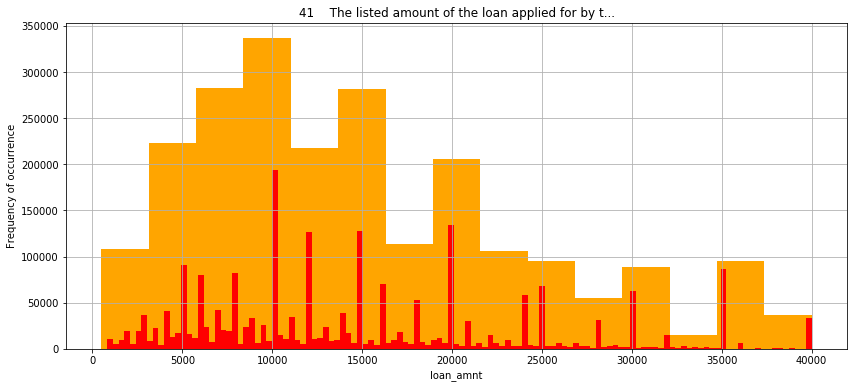

In [22]:
dfc[FEATURE].hist(bins=15, color='orange')
dfc[FEATURE].hist(bins=125, color='r')

plt.xlabel(FEATURE)
plt.ylabel('Frequency of occurrence')
plt.title(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
plt.show()

comments[FEATURE] = 'Model as int32.'

This is a number (in unkown currency). There is a user preference to seek round numbers for loan.

### 3: funded_amnt

In [23]:
FEATURE = 'funded_amnt'
print(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
print(dfc[FEATURE].describe())

23    The total amount committed to that loan at tha...
count    2.260668e+06
mean     1.504166e+04
std      9.188413e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.287500e+04
75%      2.000000e+04
max      4.000000e+04
Name: funded_amnt, dtype: float64


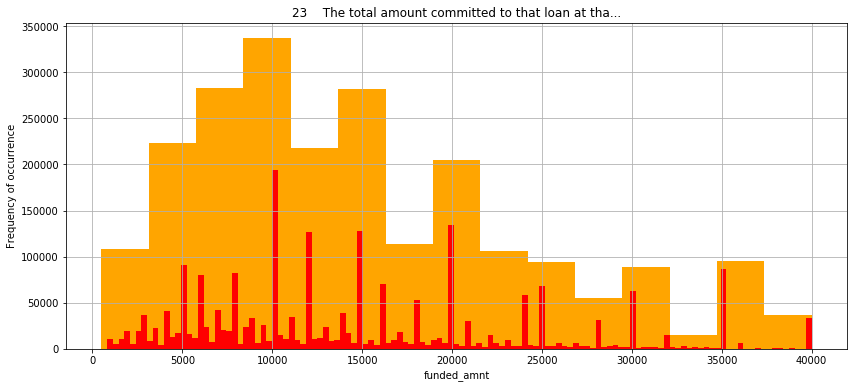

In [24]:
dfc[FEATURE].hist(bins=15, color='orange')
dfc[FEATURE].hist(bins=125, color='r')

plt.xlabel(FEATURE)
plt.ylabel('Frequency of occurrence')
plt.title(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
plt.show()

In [0]:
(dfc['loan_amnt'] == dfc[FEATURE]).sum() == len(dfc)
comments[FEATURE] = 'It is a duplicate. Eliminate it.'

### 4: `funded_amnt_inv`

24    The total amount committed by investors for th...
count    2.260668e+06
mean     1.502344e+04
std      9.192332e+03
min      0.000000e+00
25%      8.000000e+03
50%      1.280000e+04
75%      2.000000e+04
max      4.000000e+04
Name: funded_amnt_inv, dtype: float64


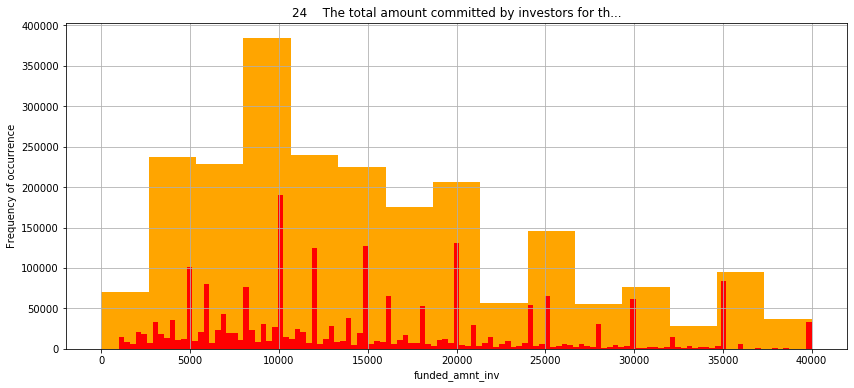

In [26]:
FEATURE = 'funded_amnt_inv'
print(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
print(dfc[FEATURE].describe())

dfc[FEATURE].hist(bins=15, color='orange')
dfc[FEATURE].hist(bins=125, color='r')
plt.xlabel(FEATURE)
plt.ylabel('Frequency of occurrence')
plt.title(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
plt.show()

dfc[FEATURE] = dfc[FEATURE].astype(np.int32)
comments[FEATURE] = 'Model as uint32.'

### 5: `term`

In [27]:
FEATURE = 'term'
print(dfc[FEATURE].unique())
print(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
print(dfc[FEATURE].describe())

comments[FEATURE] = 'To be implemented as a choice field.'

[' 36 months' ' 60 months']
94    The number of payments on the loan. Values are...
count        2260668
unique             2
top        36 months
freq         1609754
Name: term, dtype: object


### 6: `int_rate`

34    Interest Rate on the loan
count    2.260668e+06
mean     1.309291e+01
std      4.832114e+00
min      5.310000e+00
25%      9.490000e+00
50%      1.262000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64


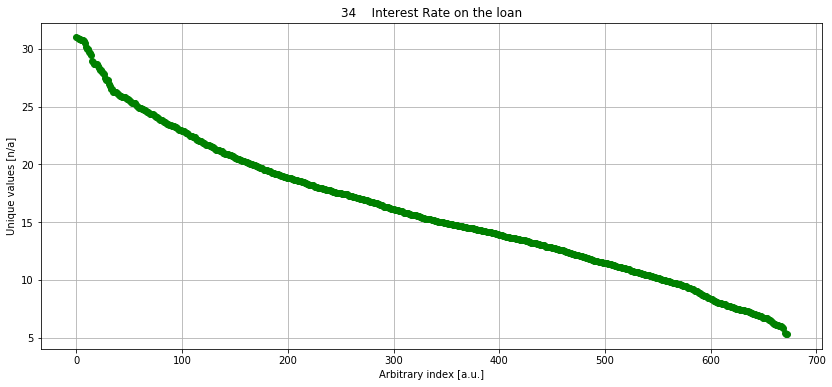

In [28]:
FEATURE = 'int_rate'
print(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
print(dfc[FEATURE].describe())

plt.plot(dfc[FEATURE].sort_values(ascending=False).unique(), 'go')
plt.xlabel('Arbitrary index [a.u.]')
plt.ylabel('Unique values [n/a]')
plt.title(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
plt.grid()
plt.show()

dfc[FEATURE] = dfc[FEATURE].astype(np.float16)

comments[FEATURE] = 'Model as float16.'

### 7: `installment`

33    The monthly payment owed by the borrower if th...
count    2.260668e+06
mean     4.458076e+02
std      2.671737e+02
min      4.930000e+00
25%      2.516500e+02
50%      3.779900e+02
75%      5.933200e+02
max      1.719830e+03
Name: installment, dtype: float64


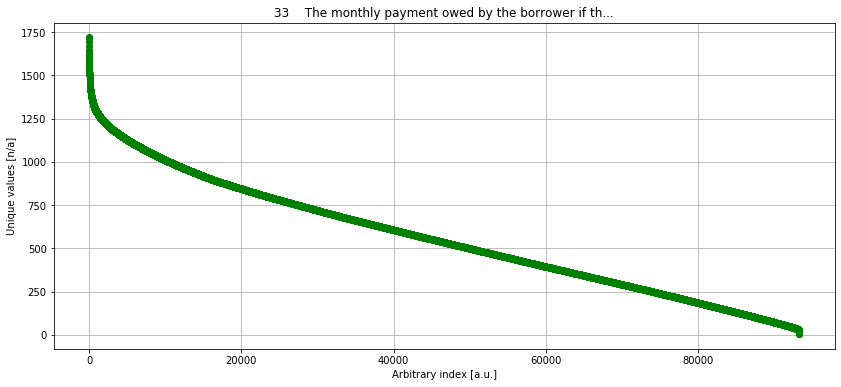

In [29]:
FEATURE = 'installment'
print(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
print(dfc[FEATURE].describe())

plt.plot(dfc[FEATURE].sort_values(ascending=False).unique(), 'go')
plt.xlabel('Arbitrary index [a.u.]')
plt.ylabel('Unique values [n/a]')
plt.title(loan_stats[loan_stats['LoanStatNew'] == FEATURE].Description.to_string())
plt.grid()
plt.show()

dfc[FEATURE] = dfc[FEATURE].astype(np.float32)

comments[FEATURE] = 'Model as float32.'

### 8: `grade`

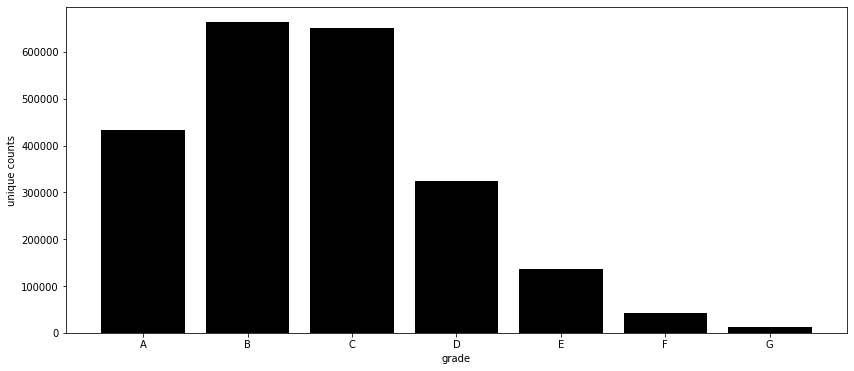

In [30]:
FEATURE = 'grade'
grade_df = pd.DataFrame(dfc[FEATURE].value_counts().sort_index())
plt.bar(grade_df.index, grade_df[FEATURE], color='k')
plt.xlabel(FEATURE)
plt.ylabel('unique counts')

plt.show()

comments[FEATURE] = 'Model as categorical, non-null.'

### 9: `sub_grade`

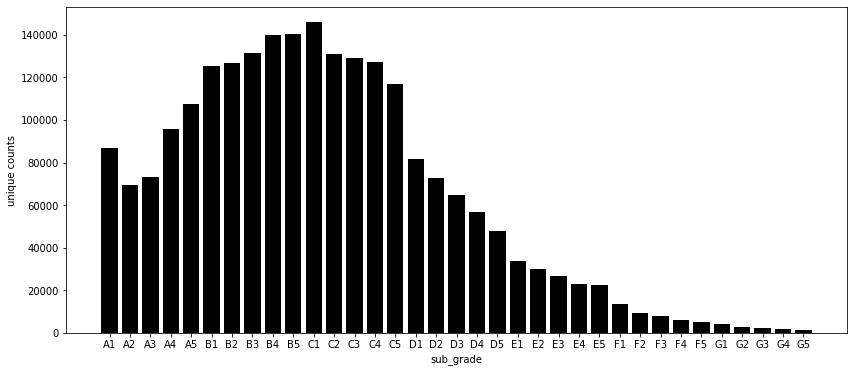

In [31]:
FEATURE = 'sub_grade'
sub_grade_df = pd.DataFrame(dfc[FEATURE].value_counts().sort_index())
plt.bar(sub_grade_df.index, sub_grade_df[FEATURE], color='k')
plt.xlabel(FEATURE)
plt.ylabel('unique counts')

plt.show()

comments[FEATURE] = 'Model as categorical, non-null.'

In [0]:
b = sub_grade_df.T
new_cols = set(map(lambda x: x[0], b.columns))
c = {}
for i in new_cols:
  c[i] = b[[j for j in b.columns if j.startswith(i)]].sum(axis=1).values[0]

(pd.DataFrame(c.values(), index=c.keys(), columns=['grade']).sort_index() == grade_df).all()

comments[FEATURE] = 'This feature duplicates `grade` with more granularity. We should use this one instead.'

## High-Level Analysis
From now on, we will be looking selected data only, which we think will deliver value to the other team. In real case situations, it would be recommended not to remove any pieces of the data from machine-learning experts, unless the data is either corrupted or it exists in a duplicated form.

Here, however, we will focus on the absolute essence only.
For this reason, we will drop all the columns that contain missing values or seem to be duplicates with respect to other portions of the data.


### Selected columns
Given the descriptions available in the auxiliary file, we can distil the dataset to formulate the following entities:
1. *Borrower* that represents of an individual that borrows money (probably a customer).
2. *Loan* that is the amount that is borrowed / granted or rejected together with financial terms and conditions.

The entities shall bear only key properties that are essential for to understand of the overall picture, without going into the low-level financial details.


**`LOAN`**:
* `id`
* `title`		The loan title provided by the borrower
* `funded_amnt`	The total amount committed to that loan at that point in time.
* `total_pymnt`	Payments received to date for total amount funded
* `sub_grade`	LC assigned loan grade
* `int_rate`	Interest Rate on the loan
* `loan_amnt`	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* `loan_status`	Current status of the loan
* `term`		The number of payments on the loan. Values are in months and can be either 36 or 60.

**`BORROWER`**:
- `LOAN` (1-M)
* `member_id`	A unique LC assigned Id for the borrower member.
* `all_util`	Balance to credit limit on all trades
* `annual_inc`	The self-reported annual income provided by the borrower during registration.
* `avg_cur_bal`	Average current balance of all accounts
* `dti`		A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* `home_ownership`	The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
* `addr_state`	The state provided by the borrower in the loan application
* `zip_code`	The first 3 numbers of the zip code provided by the borrower in the loan application.
* `emp_title`	The job title supplied by the Borrower when applying for the loan.
* `emp_length`	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.


In [0]:
selected_properties = {
    'id', 'title', 'funded_amnt', 'total_pymnt', 'sub_grade', 'int_rate', 'loan_amnt',
    'loan_status', 'term', 'all_util', 'member_id', 'annual_inc', 'avg_cur_bal', 'dti',
    'home_ownership', 'addr_state', 'zip_code', 'emp_title', 'emp_length', 
}

In [0]:
dfc = dfc[[c for c in selected_properties]]

## Analysis of the selected columns
### `loan.id`

In [35]:
dfc['id'].isna().sum() / len(dfc)

1.0

This columns represents the loan `id`, which has been purposely removed. We can treat is as a _primary key_ for the `loan` table.

### `loan.title`

In [36]:
print("Empty values: {:.2f} %".format(dfc['title'].isna().sum() / len(dfc) * 100))
print("# unique values: {:.0f}.".format(dfc['title'].str.lower().unique().shape[0]))

Empty values: 1.03 %
# unique values: 53305.


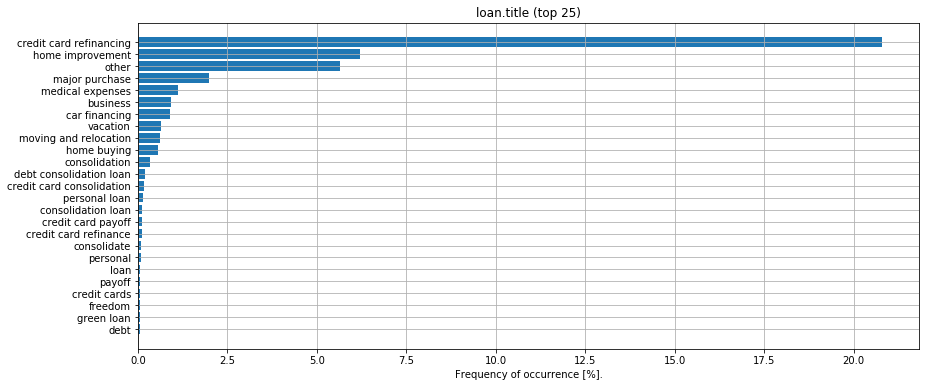

In [37]:
unique_titles = dfc['title'].str.lower().value_counts().sort_values(ascending=False)

plt.barh(unique_titles.index[25:0:-1], unique_titles[25:0:-1]/len(dfc)*100)
plt.xlabel("Frequency of occurrence [%].")
plt.title('loan.title (top 25)')
plt.grid()
plt.show()

This figure presents the top 25 `title`s, which are the "reasons" for loan as stated by the borrowers. The top reason as stated is the _credit card refinacing_, which suggests that a person seeking the loan is already in debt. The second one, as stated, is for improvement of the house, while the third one (_other_) suggests that the borrower did not want to make any excuses for seeking out loan.

Technical remark: there are some duplicates here in values. For example `credit card refinancing`, `credit card consolidation`, `credit card refinance` and `credit card payoff` bear our practically the same meaning. From algorithm development point of view, we should build the system that limits the user to more precise, narrow scope.

Here, apart from converting the text into lower case only, we will treat this field as _optional_ description over the case.

### `loan.funded_amnt`

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


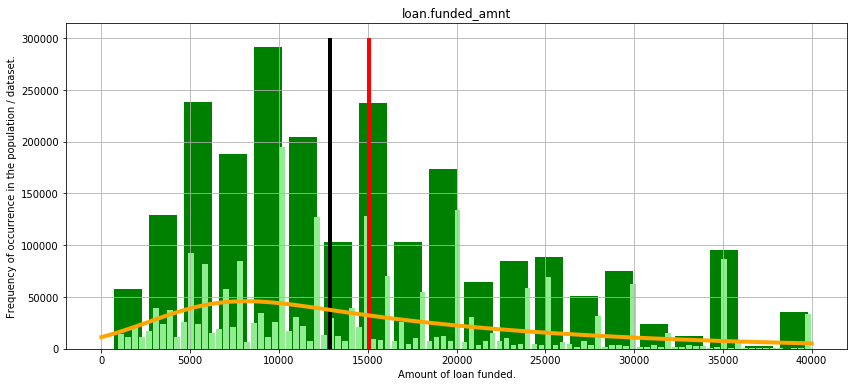

In [38]:
assert dfc['funded_amnt'].isna().sum() == 0

plt.hist(dfc['funded_amnt'], bins=20, color='green', rwidth=0.80)
plt.hist(dfc['funded_amnt'], bins=100, color='lightgreen', rwidth=0.80)
plt.vlines(dfc['funded_amnt'].mean(), 0, 3e5, 'r', lw=4)
plt.vlines(dfc['funded_amnt'].median(), 0, 3e5, 'k', lw=4)
plt.xlabel("Amount of loan funded.")
plt.ylabel("Frequency of occurrence in the population / dataset.")
plt.title("loan.funded_amnt")

from scipy.special import erfc
from scipy.optimize import curve_fit

def skewed_gaussian(x, A, mu, sigma, lam):
  a = lam/2
  b = np.exp(lam / 2 * (2*mu + lam*sigma**2 - 2*x))
  c = erfc((mu + lam*sigma**2 - x)/(np.sqrt(2)*sigma))
  return A * a * b * c

p0 = [100000, 13000, 1000, 0.0001]
linx = np.linspace(0, 40000, num=100)
vals = np.histogram(dfc['funded_amnt'], bins=100)[0]
coeff, _ = curve_fit(skewed_gaussian, linx, vals, p0=p0)
skaus = skewed_gaussian(linx, *coeff)

plt.plot(linx, skaus, 'orange', lw=4)

plt.grid()
plt.show()

Judging by the look of the histogram, we infer that the `funded_amnt` follows the so-called exponentially modified Gaussian distribution (a normal distibution that is assymetric), with mean (red) of around 15000 and median (black) of around 13000. The reason for this large differnece between the mean and median is the fact that there exists a small group of people that were granted an extremely large loans (above 35000) which skew the distribution.

Technical remark: model this column as non-optional, floating point number (float32).

...yes, it seems that the exponentially modified function is a reasonable fit:

$$
y(x; A,\mu,\sigma,\lambda) = \frac{A\lambda}{2}\exp\left(\frac{\lambda}{2}(2\mu + \lambda\sigma^2-2x)\right)\text{erfc}\left(\frac{\mu + \lambda\sigma^2 - x}{\sqrt{2}\sigma}\right).
$$

### `loan.total_pyment`

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


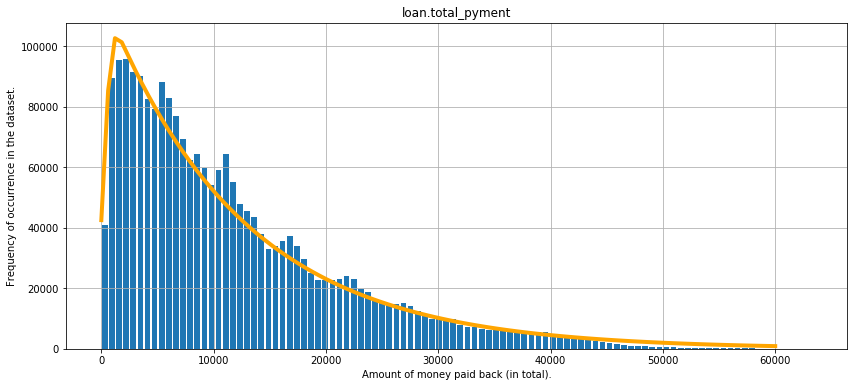

In [39]:
assert dfc['total_pymnt'].isna().sum() == 0

plt.hist(dfc['total_pymnt'], bins=100, rwidth=0.80)
plt.xlabel("Amount of money paid back (in total).")
plt.ylabel("Frequency of occurrence in the dataset.")
plt.title("loan.total_pyment")

p0 = [100000, 3000, 1000, 0.0001]
linx = np.linspace(0, 60000, num=100)
vals = np.histogram(dfc['total_pymnt'], bins=100)[0]
coeff, _ = curve_fit(skewed_gaussian, linx, vals, p0=p0)
skaus = skewed_gaussian(linx, *coeff)

plt.plot(linx, skaus, 'orange', lw=4)

plt.grid()
plt.show()

Again, the exponentially-modified function seems to be a good fit for this distribution...

Here, there are two distinct obeservations that can be made:
1. The the frequency of the pay-back is almost alwyas _inversely proportional_ to the amount paid, meaning that the larger the amount, it is proportionally less likely that it will be paid.
2. Secondly, there is a some preference among the borrowers to pay back the amount that is slighly _larger_ than any round number. Perhaps this can be understood with a fact that when a loan is paid back it incurres interest as well. However, we can clearly see points where the histogram diviates from the fitted line, which happens exactly when the argument is a round number.

Technical remark: model it as a non-zero, non-optional floating point number.

### `loan.sub_grade` -> `grade`

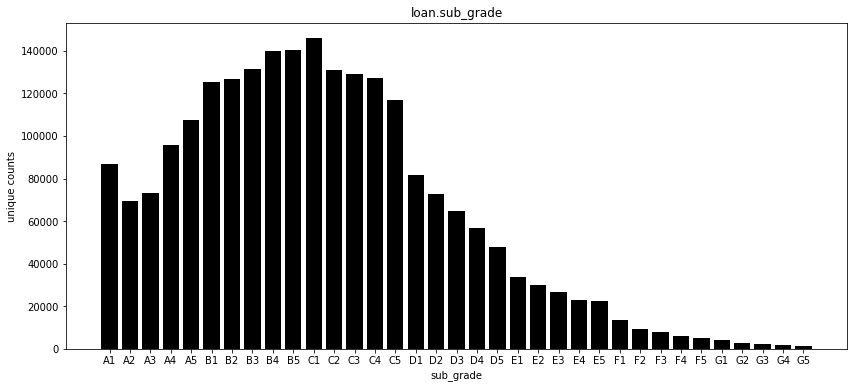

In [40]:
assert dfc['sub_grade'].isna().sum() == 0

sub_grade_df = pd.DataFrame(dfc['sub_grade'].value_counts().sort_index())
plt.bar(sub_grade_df.index, sub_grade_df['sub_grade'], color='k')
plt.xlabel('sub_grade')
plt.ylabel('unique counts')
plt.title('loan.sub_grade')

plt.show()

Again, since the elements of `sub_grade` total to `grade`, we can replace the `grade` column with `sub_grade` and the information will remain complete. At the same time, it makes no sense to retain the name `sub_grade` as such, so we will rename it to `grade` when populating of the database.

### `loan.int_rate`

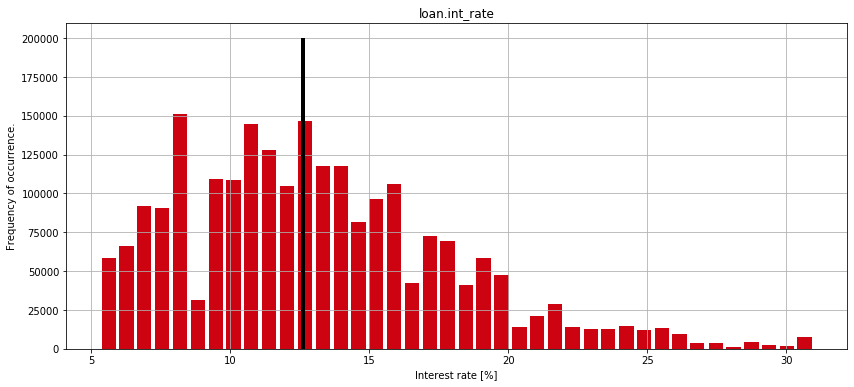

nan
12.62


In [41]:
assert dfc['int_rate'].isna().sum() == 0

plt.hist(dfc['int_rate'], bins=40, color='#CD0312', rwidth=0.80)
plt.vlines(dfc['int_rate'].mean(), 0, 1.5e4, 'g', lw=4)
plt.vlines(dfc['int_rate'].median(), 0, 2e5, 'k', lw=4)
plt.xlabel('Interest rate [%]')
plt.ylabel('Frequency of occurrence.')
plt.title('loan.int_rate')
plt.grid()
plt.show()

print (dfc['int_rate'].mean())
print (dfc['int_rate'].median())

The interest rates span across interval of 5 to 30+ per cent, with median equal to 12.62% (and mean being undefined).
There is a significant tail in the distribution where some customers have been offered (and apparently accepted) interest rates of 20 per cent and above... poor men.

### `loan.loan_amnt`

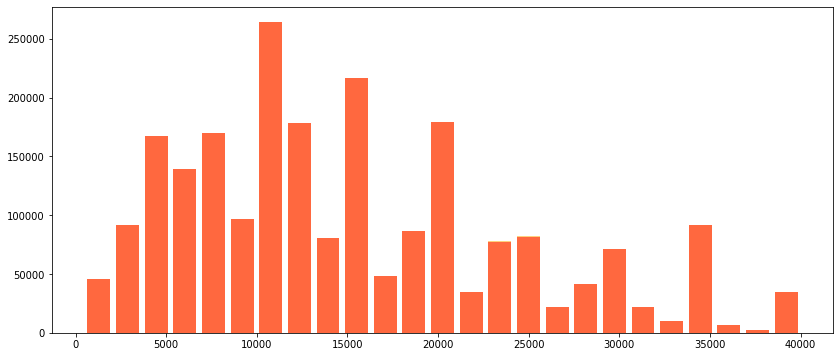

In [42]:
assert dfc['loan_amnt'].isna().sum() == 0

if (dfc['loan_amnt'] == dfc['funded_amnt']).all():
  print ('Loan amount and funded amount are the same things!')
else:
  plt.hist(dfc['loan_amnt'], bins=25, color='orange', alpha=0.5, rwidth=0.80)
  plt.hist(dfc['funded_amnt'], bins=25, color='red', alpha=0.5, rwidth=0.80)
  plt.show()


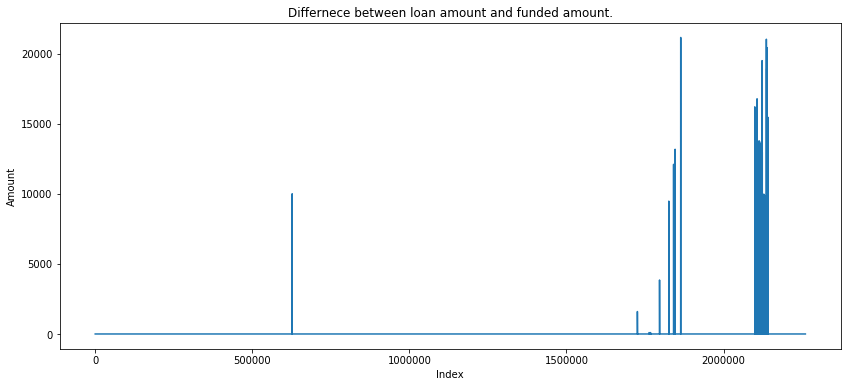

Discrepancies: 0.09%


In [43]:
plt.plot(dfc['loan_amnt'] - dfc['funded_amnt'])
plt.xlabel('Index')
plt.ylabel('Amount')
plt.title('Differnece between loan amount and funded amount.')
plt.show()

print ("Discrepancies: {:.2f}%".format(((dfc['loan_amnt'] - dfc['funded_amnt']) != 0.0).sum() / len(dfc) * 100))

Distribution-wise the `loan_amnt` is equal to `funded_amnt`. However, by element-wise subtraction, we can see that the there exist discrepencies that are present in the 0.09% of the whole population (counted as a sum of non-zero difference positions).

### `loan.loan_status`

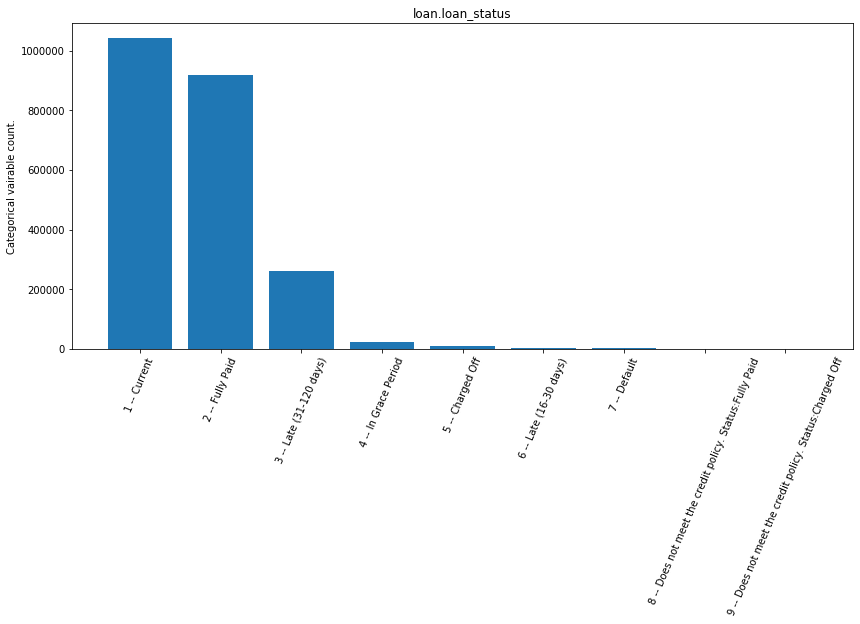

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64


In [44]:
assert dfc['loan_status'].isna().sum() == 0

ind = list(map(lambda x: str(x[0] + 1) + ' -- ' + str(x[1]), enumerate(dfc['loan_status'].unique())))
sdf = pd.DataFrame(dfc['loan_status'].value_counts().sort_values(ascending=False))
plt.bar(ind, sdf['loan_status'])
plt.title('loan.loan_status')
plt.xticks(rotation=67)
plt.ylabel("Categorical vairable count.")

plt.show()
del sdf

print(dfc['loan_status'].value_counts())

Here, we have a categorical variable that describes of what happens with the loan. Here, there is a similarity between 3. and 5. value, as well as 6. and 7. are somewhat similar to 1. and 3.

From this perspective, it would make sense to split this variable into two:
1. `loan.loan_status` to `loan.loan_status` containing values 1.-6. + 9.
2. `loan.meets_policy` being a binary field that would discriminate 7. and 8. (`True`) from the rest (`False`).

### `loan.term`

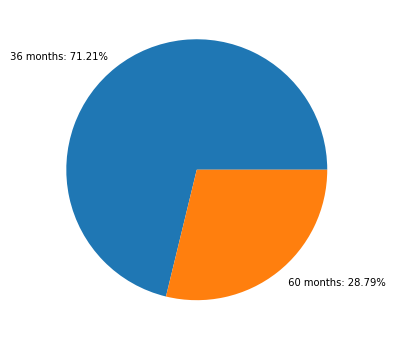

In [45]:
assert dfc['term'].isna().sum() == 0.0

prop = zip(dfc['term'].value_counts().index, dfc['term'].value_counts() / len(dfc))
labels = list(map(lambda x: str(x[0]) + ': ' + '{:.2f}%'.format(x[1] * 100), prop))
plt.pie(dfc['term'].value_counts() / len(dfc), labels=labels)
plt.show()

Here, we see only two unique values: 36 or 60 months and the whole column lacks empty values. We can model it as is.

### `borrower.all_util`
Balance to credit limit on all trades.

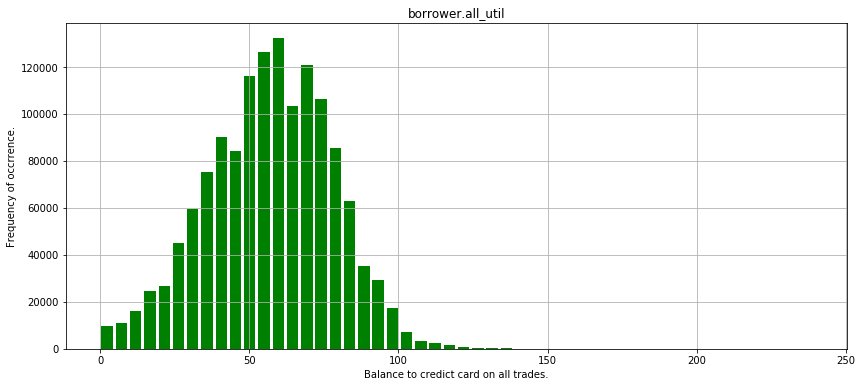

count    1.394320e+06
mean     5.703230e+01
std      2.090475e+01
min      0.000000e+00
25%      4.300000e+01
50%      5.800000e+01
75%      7.200000e+01
max      2.390000e+02
Name: all_util, dtype: float64
Outliers (x > 150): 89 out of 2260668.
Missing values: 866348 out of 2260668.


In [46]:
assert dfc[dfc['all_util'] < 0.0].shape[0] == 0

plt.hist(dfc[~dfc['all_util'].isna()]['all_util'], bins=50, color='green', rwidth=0.80)
plt.title('borrower.all_util')
plt.xlabel('Balance to credict card on all trades.')
plt.ylabel('Frequency of occrrence.')
plt.grid()
plt.show()

print (dfc['all_util'].describe())
print ("Outliers (x > 150): {} out of {}.".format(
    dfc[dfc['all_util'] > 150.0].shape[0], len(dfc)))
print ("Missing values: {} out of {}.".format(
    dfc['all_util'].isna().sum(), len(dfc)))

These values formulate a nearly-Gaussian distribution, although around 38% of the entries are empty.

Possible assertions on the data could mean ensuring that $x \ge 0$, but it is hard to establish if the `NULL` values should be converted to e.g. 0 or not without a domain expert.

### `borrower.annual_inc`
The self-reported annual income provided by the borrower during registration.

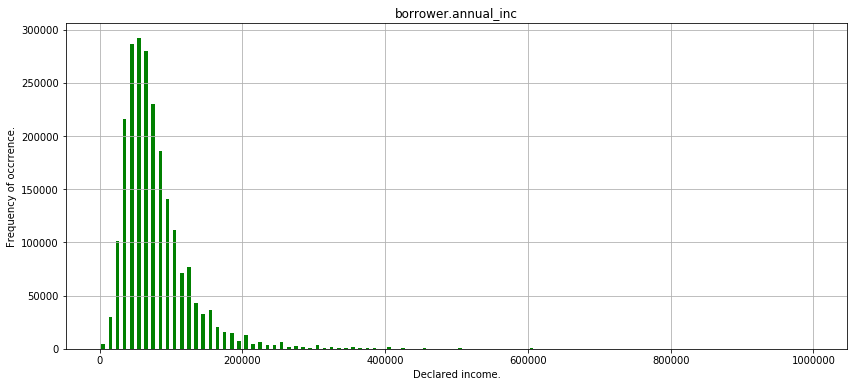

count    2.260664e+06
mean     7.799243e+04
std      1.126962e+05
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.300000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64
Outliers (x > 1M): 678 out of 2260668.
Missing values: 4 out of 2260668.


In [47]:
assert dfc[dfc['annual_inc'] < 0.0].shape[0] == 0

plt.hist(dfc[dfc['annual_inc'] < 1e6]['annual_inc'], bins=100, color='green', rwidth=0.5)
plt.title('borrower.annual_inc')
plt.xlabel('Declared income.')
plt.ylabel('Frequency of occrrence.')
plt.grid()
plt.show()

print (dfc['annual_inc'].describe())
print ("Outliers (x > 1M): {} out of {}.".format(
    dfc[dfc['annual_inc'] >= 1e6].shape[0], len(dfc)))
print ("Missing values: {} out of {}.".format(
    dfc['annual_inc'].isna().sum(), len(dfc)))

This graph represent the declared annual income.
It follows an exponentially modified Gaussian distribution,
Interestingly, 678 people declared their income to be above 1M, which is a considerable income. Perhaps, we should limit these values to $x \le 0 \le 10^7$ and "clip" all the values to this interval. Otherwise it becomes unrealistic and the outliers have the potential to skew the algorithms.

### `borrower.avg_cur_bal`
Average current balance of all accounts

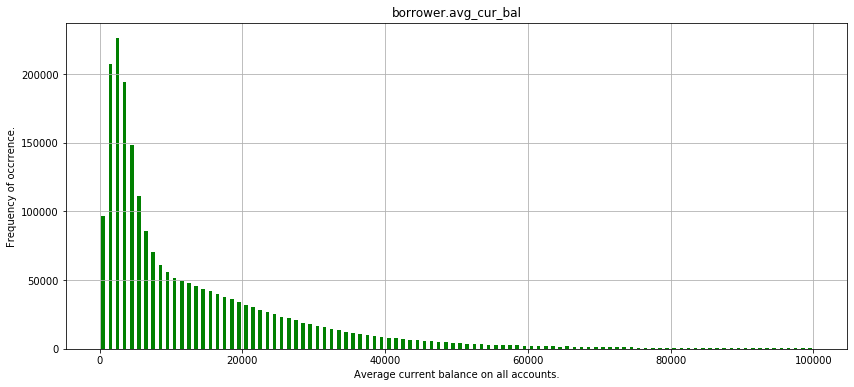

count    2.190322e+06
mean     1.354780e+04
std      1.647408e+04
min      0.000000e+00
25%      3.080000e+03
50%      7.335000e+03
75%      1.878300e+04
max      9.580840e+05
Name: avg_cur_bal, dtype: float64
Outliers (x > 1e5): 7924 out of 2260668.
Missing values: 70346 out of 2260668.


In [48]:
assert dfc[dfc['avg_cur_bal'] < 0.0].shape[0] == 0

plt.hist(dfc[dfc['avg_cur_bal'] < 1e5]['avg_cur_bal'], bins=100, color='green', rwidth=0.5)
plt.title('borrower.avg_cur_bal')
plt.xlabel('Average current balance on all accounts.')
plt.ylabel('Frequency of occrrence.')
plt.grid()
plt.show()

print (dfc['avg_cur_bal'].describe())
print ("Outliers (x > 1e5): {} out of {}.".format(
    dfc[dfc['avg_cur_bal'] >= 1e5].shape[0], len(dfc)))
print ("Missing values: {} out of {}.".format(
    dfc['avg_cur_bal'].isna().sum(), len(dfc)))

There is a marginal count average account balance values that are above $10^5$. Apart from that we have a distibution that seems to be a sum of Gaussian distribution (for lower values), then an exponential decay and eventually a flat line.

### `borrower.dti`
A ratio calculated using the borrower's total monthly debt payments on the dotal debt oblications, exluding mortgage and rhe requisted LC loan, divided by the borrower's self-reported montly income.

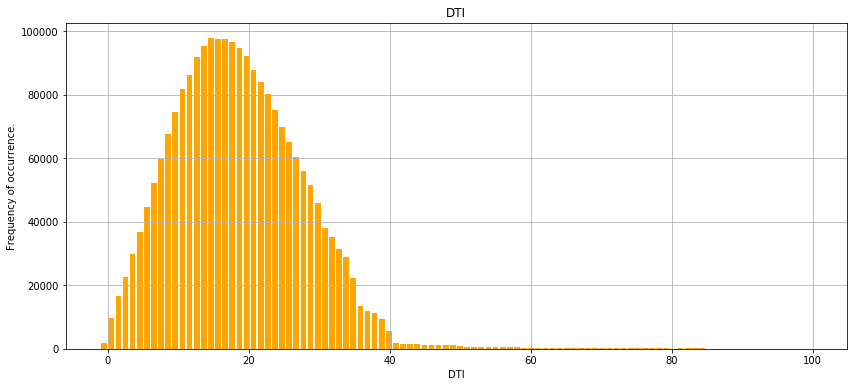

count    2.258957e+06
mean     1.882420e+01
std      1.418333e+01
min     -1.000000e+00
25%      1.189000e+01
50%      1.784000e+01
75%      2.449000e+01
max      9.990000e+02
Name: dti, dtype: float64
Outliers (x > 100): 2567 out of 2260668.
Missing values: 1711 out of 2260668.


In [49]:
plt.hist(dfc[dfc['dti'] < 100]['dti'], bins=100, color='orange', rwidth=0.8)
plt.xlabel('DTI')
plt.ylabel('Frequency of occurrence.')
plt.title('DTI')
plt.grid()
plt.show()

print (dfc['dti'].describe())
print ("Outliers (x > 100): {} out of {}.".format(
    dfc[dfc['dti'] >= 100].shape[0], len(dfc)))
print ("Missing values: {} out of {}.".format(
    dfc['dti'].isna().sum(), len(dfc)))

This value can be derived from other values, according to the description. However, as the description itself is infomrative, it makes sense to keep it. 
The distribution looks like an inverted square function with a small tail, but mostly $ax^2 + bx + c, a < 0$.

### `borrower.home_ownership`
The home ownership provided by the borrower duting registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER.

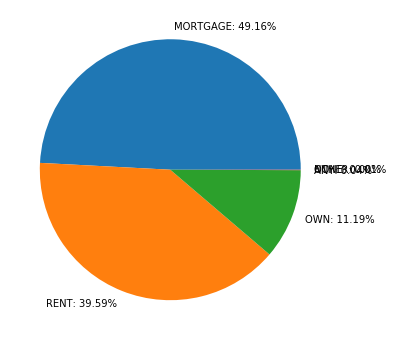

In [50]:
assert dfc['home_ownership'].isna().sum() == 0.0

prop = zip(dfc['home_ownership'].value_counts().index, dfc['home_ownership'].value_counts() / len(dfc))
labels = list(map(lambda x: str(x[0]) + ': ' + '{:.2f}%'.format(x[1] * 100), prop))
plt.pie(dfc['home_ownership'].value_counts() / len(dfc), labels=labels)
plt.show()

In [51]:
print(dfc['home_ownership'].value_counts())

MORTGAGE    1111450
RENT         894929
OWN          253057
ANY             996
OTHER           182
NONE             54
Name: home_ownership, dtype: int64


Here, there are four unique keywords declared, but in practice there are six used. Since the difference between ANY, NONE and OTHER is small when it comes to overall proportion, we can clean this data and merge whatever value there is that is undeclared to OTHER, just to represent it as a default option.

### `borrower.state`
The state provided by the borrower in the loan application.

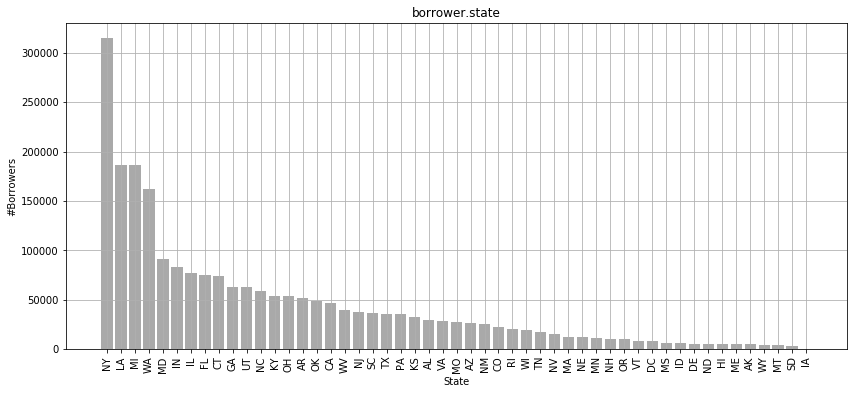

In [52]:
assert dfc['addr_state'].isna().sum() == 0

plt.bar(dfc['addr_state'].unique(), dfc['addr_state'].value_counts(), color='darkgray')
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('#Borrowers')
plt.title('borrower.state')
plt.grid()
plt.show()

In [0]:
import folium
from folium.plugins import HeatMap

def generateBaseMap(default_location=[40, -95], default_zoom_start=4):
    base_map = folium.Map(location=default_location,
                          width=800, 
                          height=600,
                          zoom_control=False,
                          no_touch=True,
                          tiles='Stamen Toner', 
                          control_scale=False,
                          zoom_start=default_zoom_start)
    return base_map

In [54]:
zcdf = pd.read_csv('./zipcodes.csv')

zipcodes = dfc[~dfc['zip_code'].isna()]['zip_code']

zcdf['zip3'] = zcdf['ZIP'].apply(lambda x: str(x))
zcdf['zip3'] = zcdf['zip3'].apply(lambda x: x[:3])
zcdf = zcdf.groupby('zip3').mean()

zipcodes = zipcodes.apply(lambda x: x[:3])

coords = pd.merge(zipcodes, zcdf, left_on='zip_code', right_on='zip3', how='inner')
coords = coords.groupby('zip_code').agg({'zip_code': ['count'], 'LAT': ['mean'], 'LNG': ['mean']})
coords.columns = ['count', 'latitude', 'longitude']
coords.head()

,count,latitude,longitude
zip_code,,,
100,17103,40.984115,-73.760131
101,800,40.987406,-73.772467
102,221,41.540736,-73.306578
103,5377,41.322870,-73.460247
104,16374,40.901209,-73.830671


In [55]:
base_map = generateBaseMap()
HeatMap(data=coords[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(),
        radius=8, max_zoom=13).add_to(base_map)
base_map

#### Brief explanation of the process.

We use `folium` that is a library, which allows geospatial visualization and creates interactive maps.
We then use a `Stamer Toner` form to make it black and white, in order to reduce the interference of the map's intrinsic features with our visualizaion.

The next step is to translate the zip codes to coordinates, which is done using a lookup table (see: [this gist](https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data)),
and picking it up as a csv file with pandas. The earier approach with installing `pyzipcode` library through pip failed on Google Collaboratory.

Becase our original data frame does not resolve the zip codes complitely, meaning, we only see the first three digits, we can only infer the localization approximately. For this reason, we strip the 4th and 5th character from the original zip codes (using `.apply(lambda x: x[:3])`) in both original and the cooridinates lookup table, respectively, so we can merge the two.

Having the mapping available, we average the cooridinates across the approximate locations and create a heat map visualization over our base map. The nice property is that if we zoom in, we can see the localizations more exactly, to the extent possible. We can also see that the spatial distribution of our *borrowers* matches pretty well the population distribution of the US inhabitants. To take a step further, we could find a dataset of the latter case and subtract it from our borrowers' distibution to see where our customer base would be out of proportion. This exercise is however beyond the current task.

### `borrower.emp_title`
The job title supplied by the Borrower when applying for the loan.

In [56]:
print ("Employment title not given: ", dfc['emp_title'].isna().sum()/len(dfc)*100, '%')
print ("Unique titles (before cleaning): ", dfc['emp_title'].unique().shape[0])
import string
emp_titles = dfc['emp_title']
emp_titles = emp_titles.replace(np.nan, '')
emp_titles = emp_titles.str.lower()
emp_titles = emp_titles.apply(lambda x: x.rstrip())
emp_titles = emp_titles.apply(lambda x: x.lstrip())
emp_titles = emp_titles.apply(lambda x: ''.join(list(filter(lambda y: y in string.ascii_lowercase, x))))
print ("Unique titles (after cleaning): ", len(emp_titles.unique()))

Employment title not given:  7.385825782467837 %
Unique titles (before cleaning):  512695
Unique titles (after cleaning):  379899


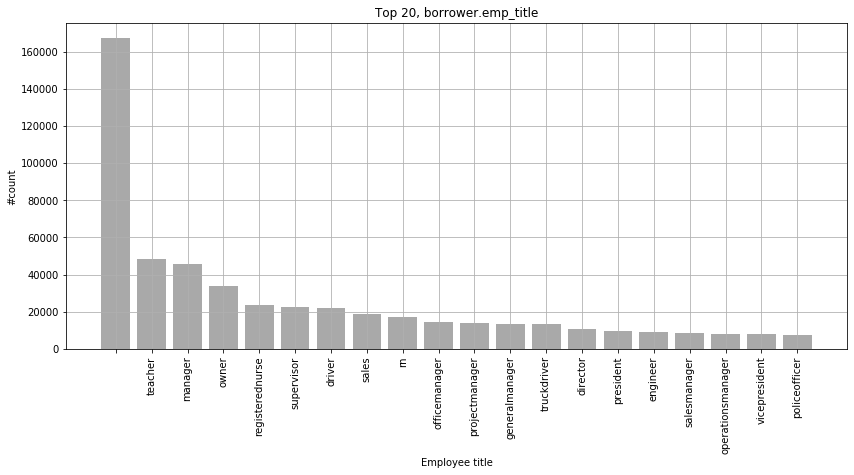

In [57]:
titles = emp_titles.value_counts()
plt.bar(titles.index[:20], titles[:20], color='darkgray')
plt.xticks(rotation=90)
plt.xlabel('Employee title')
plt.ylabel('#count')
plt.title('Top 20, borrower.emp_title')
plt.grid()
plt.show()

In [58]:
print(titles)

                                    167121
teacher                              48473
manager                              45879
owner                                33611
registerednurse                      23459
                                     ...  
cedarwoodconsultingllc                   1
fieldservicespecialistiii                1
supervisorofengineeringdept              1
lockboxspecialistiii                     1
workforcedevelopmentcouncilofskc         1
Name: emp_title, Length: 379899, dtype: int64


This is an "impossible" column. In a sense, it is descriptive, but as we can see, people have provided a lot of inconsistent or stupid values (e.g. 'aa') or did not provide a value at all.
On the other hand, we can still get some insight from it, if we plot the top most common values.
In order to do that, we have to clean the data a little, in order to strip it from "strange" (e.g. non-ASCII) characters and trim spaces. The simple procedure above already reduces the unique count of these titles by roughly 25%. 

### `borrower.emp_length`
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.


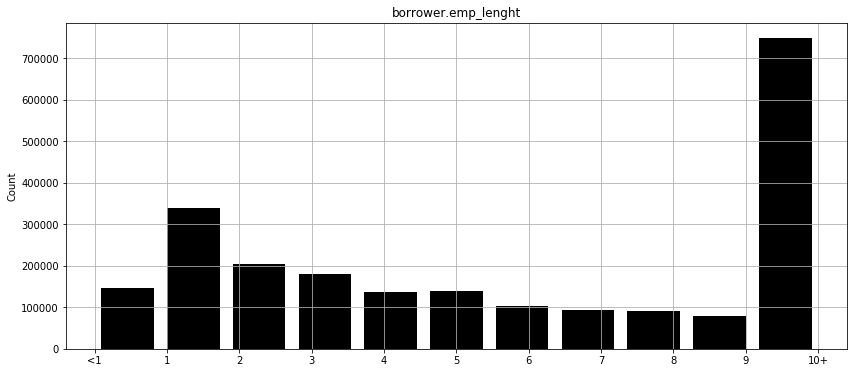

In [59]:
import re
emp_length = dfc['emp_length'].fillna('0').apply(lambda x: re.sub("\D", "", x)).astype(np.int8)

plt.hist(emp_length, bins=11, color='k', rwidth=0.8)
plt.xticks(range(11), labels=(['<1'] + [str(c) for c in range(1, 10)] + ['10+']))
plt.ylabel('Count')
plt.title('borrower.emp_lenght')
plt.grid()
plt.show()

This data is fairly consistent and hence cleaning is also easy.
We convert the values to integers, by extracting the digits from strings. At the same time, we honor the convention that any value that is 10 years or more is lumped into 10 years, while NaNs are replaced with 0, meaning that the default assumption is that if the employment length is not given, it falls back on 0.

## Next Steps
Normally, we would continue with EDA trying to identify correlations between different columns as a base for algorithm development. However, here it is more important to _normalize_ the data and create a warehouse instead.

For this reason, we would like to organize the data in a relational way, basically formulating two tables:
1. _borrowers_, where every row will be a unique customer that borrows money from LC, and
2. _loans_, where every row will be a unique loan.
The relationship between loans and members will be many-to-one, meaning, one borrower may have several registered loans, but one loan may one and only one designated "owner".

For this to work, we must first re-create `id` and `member_id`'s which have been removed from both .csv file and sqlite database.

As we will characterize the borrowers by columns we mentioned earilier, we shall extract them from the main dataframe by imposing a uniqness condition over all of the fields existing together. At the same time, the loans will be enumerated simply using indices.
We can then relate one to the other by creating a hash in the borrowers tables that will be used to temporarily enumerate the rows and merge them with the original dataframe in order for the _loans_ table to acquire a reference.





In [0]:
dfc['id'] = dfc.index

In [61]:
BORROWERS = ['all_util', 'annual_inc', 'avg_cur_bal', 'dti', 'home_ownership', 'addr_state', 'zip_code', 'emp_title', 'emp_length']
borrowers = dfc[BORROWERS]
borrowers = borrowers.drop_duplicates(subset=BORROWERS)
borrowers['hash'] = borrowers.apply(lambda x: hash((*x,)), axis=1)
borrowers['member_id'] = borrowers.index

print(len(borrowers), len(dfc))

2260637 2260668


In [62]:
dfc['hash'] = dfc[BORROWERS].apply(lambda x: hash((*x,)), axis=1)
dfc = pd.merge(dfc[[c for c in dfc.columns if c != 'member_id']], borrowers[['member_id', 'hash']], on='hash', how='left')
dfc = dfc.drop(columns=['hash'])
dfc.head()

,loan_amnt,all_util,emp_title,funded_amnt,home_ownership,addr_state,title,annual_inc,avg_cur_bal,loan_status,sub_grade,int_rate,term,dti,zip_code,id,emp_length,total_pymnt,member_id
0,2500,28.0,Chef,2500,RENT,NY,Debt consolidation,55000.0,1878.0,Current,C1,13.562500,36 months,18.24,109xx,0,10+ years,167.02,0
1,30000,57.0,Postmaster,30000,MORTGAGE,LA,Debt consolidation,90000.0,24763.0,Current,D2,18.937500,60 months,26.52,713xx,1,10+ years,1507.11,1
2,5000,35.0,Administrative,5000,MORTGAGE,MI,Debt consolidation,59280.0,18383.0,Current,D1,17.968750,36 months,10.51,490xx,2,6 years,353.89,2
3,4000,70.0,IT Supervisor,4000,MORTGAGE,WA,Debt consolidation,92000.0,30505.0,Current,D2,18.937500,36 months,16.74,985xx,3,10+ years,286.71,3
4,30000,54.0,Mechanic,30000,MORTGAGE,MD,Debt consolidation,57250.0,9667.0,Current,C4,16.140625,60 months,26.35,212xx,4,10+ years,1423.21,4


In [63]:
LOANS = ['title', 'funded_amnt', 'total_pymnt', 'sub_grade', 'int_rate', 'loan_amnt', 'loan_status', 'term', 'member_id']
loans = dfc[LOANS]
loans = loans.drop_duplicates(subset=LOANS)
loans['id'] = loans.index

print(len(loans), len(dfc))

2260668 2260668


In [64]:
a = loans.groupby('member_id').count()['id'].sort_values(ascending=False)
a = a.reset_index()
a.columns = ['member_id', 'count']
a[a['count'] > 1]

loans[loans['member_id'] == 2141934]

,title,funded_amnt,total_pymnt,sub_grade,int_rate,loan_amnt,loan_status,term,member_id,id
2141934,Moving expenses,5000,5593.631614,A2,7.429688,5000,Does not meet the credit policy. Status:Fully ...,36 months,2141934,2141934
2141935,Education,7000,7867.655865,A3,7.750000,7000,Does not meet the credit policy. Status:Fully ...,36 months,2141934,2141935
2141965,Moving expenses and security deposit,6700,7530.481427,A3,7.750000,6700,Does not meet the credit policy. Status:Fully ...,36 months,2141934,2141965


Having the two tables separated, we can easily see that some borrowers possess more than one loan. Especially, a borrower of `id = 2141934` is an owner of three loans at the same time.

Let's save the newely created tables in designated files.
We will use these tables to define a schema in a new database, and populate it with their records.

In [0]:
loans['id'] = loans['id'] + 1 # make the df index the PK in database
loans['member_id'] = loans['member_id'] + 1
borrowers['member_id'] = borrowers['member_id'] + 1

PROJECT_PATH = '/content/drive/My Drive/'

loans.to_csv(join(PROJECT_PATH, 'loans_tbl.csv'))
borrowers.to_csv(join(PROJECT_PATH, 'borrowers_tbl.csv'))